In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
# read in dataframe
df = pd.read_csv('final_data_files/uncrowded_everything_all_clipped.csv')#_clipped.csv')

# show column names for reference
print df.columns.values

['id' 'type' 'per' 'mag_j' 'merr_j' 'mag_h' 'merr_h' 'mag_k' 'merr_k'
 'mag_3' 'merr_3' 'mag_4' 'merr_4' 'resid_m4_j' 'resid_m4_h' 'resid_m4_k'
 'resid_m4_3' 'resid_m4_4' 'resid_all_j' 'resid_all_h' 'resid_all_k'
 'resid_all_3' 'resid_all_4' 'photfeh' 'photfeh_err' 'spectfeh'
 'spectfeh_err']


In [9]:
# define line-fitting function
def fitfunc(x,slope,intc):
    return slope*x + intc

# make the figure and subplots

def make_plot(wav, df, lam):
    resid_name = 'resid_all_{}'.format(wav.lower())
    merr_name = 'merr_{}'.format(wav.lower())
    condition_1 = (np.isfinite(df[resid_name]))
    # select only rows with non-nan spectroscopic metallicities
    condition_2 = (np.isfinite(df.spectfeh))
    # select only rows with non-nan photometric metallicities
    condition_3 = (np.isfinite(df.photfeh))
    condition_4 = (df.type == 0)
    
    df1 = df[condition_1 & condition_2 & condition_4] # spectroscopic rrab
    df2 = df[condition_1 & condition_3 & condition_4] # photometric rrab
    df3 = df[condition_1 & condition_2 & ~condition_4] # spectroscopic rrc
    df4 = df[condition_1 & condition_3 & ~condition_4] # photometric rrc
    
    resids2 = [df1[resid_name], df2[resid_name], df3[resid_name], df4[resid_name]]
    fehs2 = [df1['spectfeh'], df2['photfeh'], df3['spectfeh'], df4['photfeh']]
    resid_errs2 = [df1[merr_name], df2[merr_name], df3[merr_name], df4[merr_name]]
    feh_errs2 = [df1['spectfeh_err'], df2['photfeh_err'], df3['spectfeh_err'], df4['photfeh_err']]
    labels = ['RRab', 'RRab', 'RRc', 'RRc']

    fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,5))
    ax = ax.ravel()

    for i in range(4):
        if i % 2 == 0:
            metallicity = 'spectroscopic'
        else:
            metallicity = 'photometric'
        if labels[i] == 'RRab':
            ax[i].plot(fehs2[i].values, resids2[i].values, 'ok')
        else:
            ax[i].plot(fehs2[i].values, resids2[i].values, '^k')
        ax[i].errorbar(-2.3 + feh_errs2[i].mean() + 0.05,-0.59,
                       yerr=resid_errs2[i].mean(),xerr=feh_errs2[i].mean(),fmt=',',color='k')
        x = np.linspace(-4, 0, 3)
        popt, pcov = curve_fit(fitfunc, fehs2[i], resids2[i])
        sig = np.sqrt(np.diag(pcov))
        y1 = popt[0] * x + popt[1]
        y2 = (popt[0] + sig[0]) * x + (popt[1] + sig[1])
        y3 = (popt[0] - sig[0]) * x + (popt[1] - sig[1])
        ppl.plot(ax[i],x,y1,'k-',lw=2)
        ppl.plot(ax[i],x,y2,'k--')
        ppl.plot(ax[i],x,y3,'k--')
        ax[i].text(-0.89,0.62,r'$\gamma$ = ${:.3f} \pm {:.3f}$'.format(popt[0], sig[0]),
                   va='top', ha='right')
        print ','.join(map(str, [wav, lam, metallicity, labels[i], popt[0], sig[0], popt[1], sig[1]]))
    ax[-2].set_xlabel('[Fe/H], spectroscopic')
    ax[-1].set_xlabel('[Fe/H], photometric')
    if wav == '3':
        ax[0].set_ylabel('$\Delta [3.6]$, RRab')
        ax[2].set_ylabel('$\Delta [3.6]$, RRc')        
    elif wav == '4':
        ax[0].set_ylabel('$\Delta [4.5]$, RRab')
        ax[2].set_ylabel('$\Delta [4.5]$, RRc')        
    elif wav.upper() == 'K':
        ax[0].set_ylabel('$\Delta K_s$, RRab')
        ax[2].set_ylabel('$\Delta K_s$, RRc')        
    else:
        ax[0].set_ylabel('$\Delta {}$, RRab'.format(wav.upper()))
        ax[2].set_ylabel('$\Delta {}$, RRc'.format(wav.upper()))
    ax[0].set_ylim(-0.69,0.69)
    #ax1.set_xlim(-2.75,-0.25)
    ax[0].set_xlim(-2.3,-0.85)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.08,wspace=0.05)
    fig.savefig('final_plots/metallicity_vs_residuals_{}.pdf'.format(wav))

J,1.22,spectroscopic,RRab,-0.176890566259,0.108275579733,-0.274958270083,0.171804057164
J,1.22,photometric,RRab,-0.10675053041,0.0748745991061,-0.168896860838,0.123370951392
J,1.22,spectroscopic,RRc,0.087434076609,0.133865174727,0.183202945669,0.231399031948
J,1.22,photometric,RRc,0.0243870853241,0.0367537244872,0.0410310258265,0.0573016707328
H,1.63,spectroscopic,RRab,-0.0767656432243,0.147311041613,-0.1413314879,0.23374277542
H,1.63,photometric,RRab,-0.0798609358967,0.102984011697,-0.127234789054,0.168713110915
H,1.63,spectroscopic,RRc,0.094523323558,0.216596609114,0.21107005374,0.374408401244
H,1.63,photometric,RRc,-0.0195242422805,0.0586960316083,-0.0015184749456,0.0915112942096
K,2.19,spectroscopic,RRab,-0.159646639263,0.112367695905,-0.258515758073,0.178297139996
K,2.19,photometric,RRab,-0.0808475674738,0.0885306241628,-0.121171085695,0.144805398333
K,2.19,spectroscopic,RRc,0.13664597985,0.174067283293,0.285949854445,0.300892303797
K,2.19,photometric,RRc,-0.00644536944942,0.03929

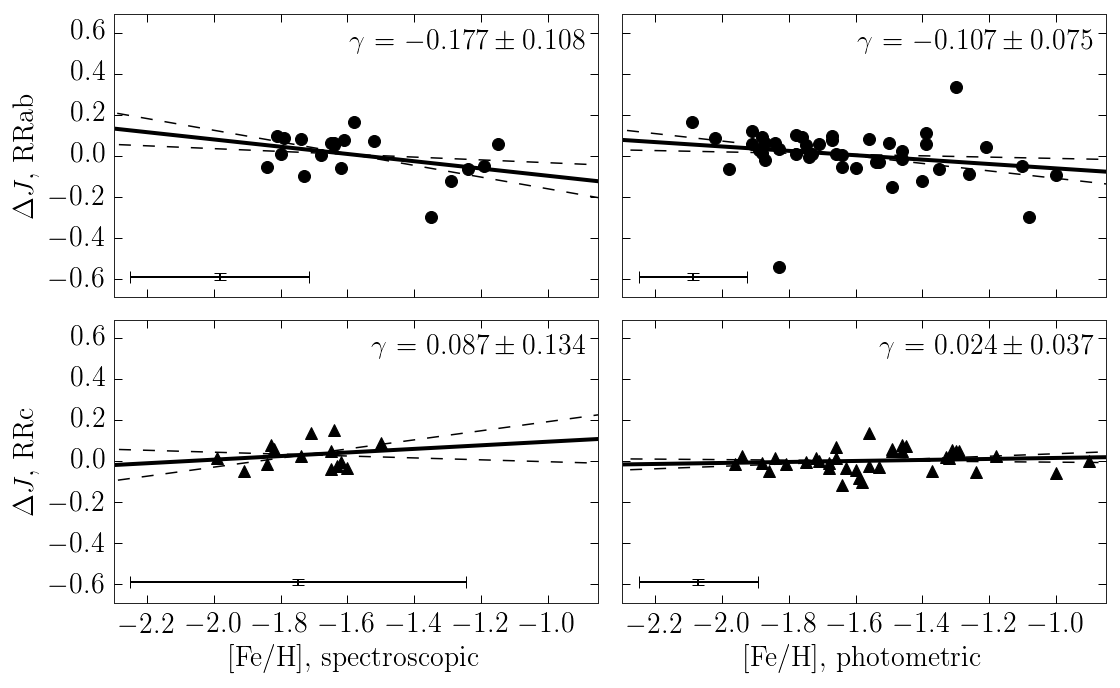

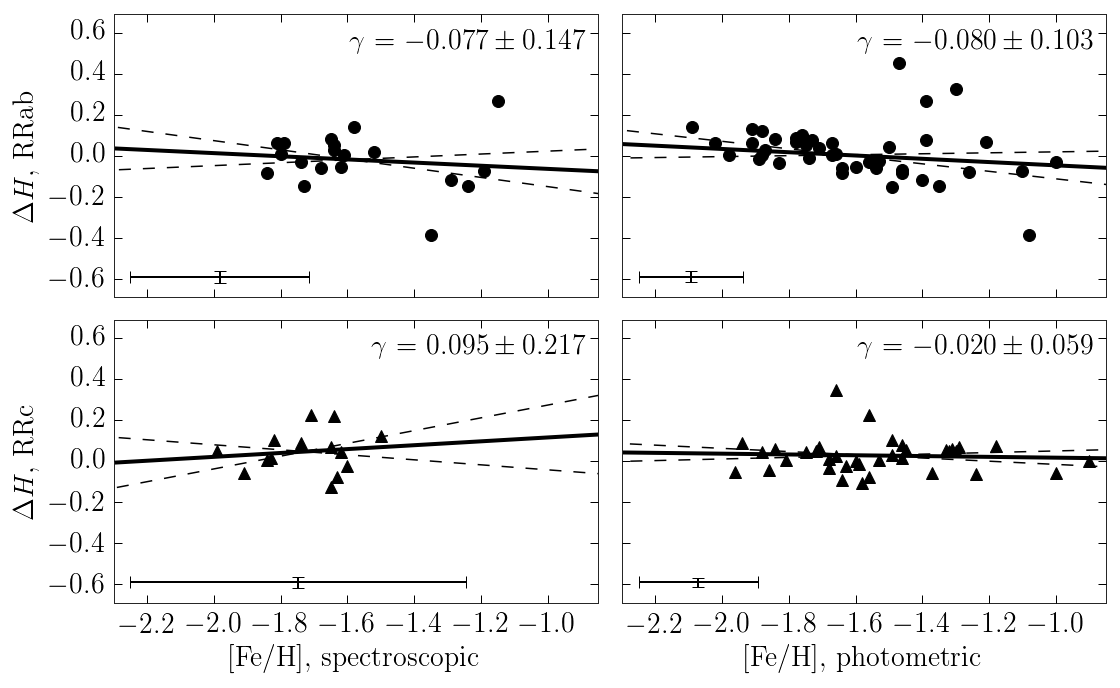

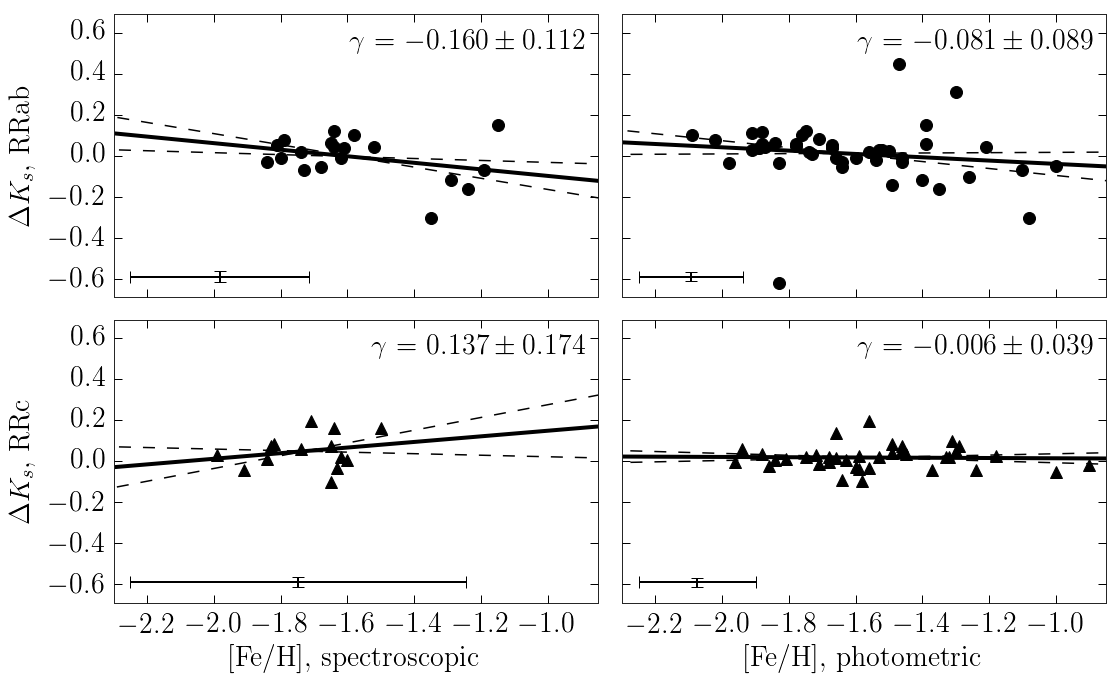

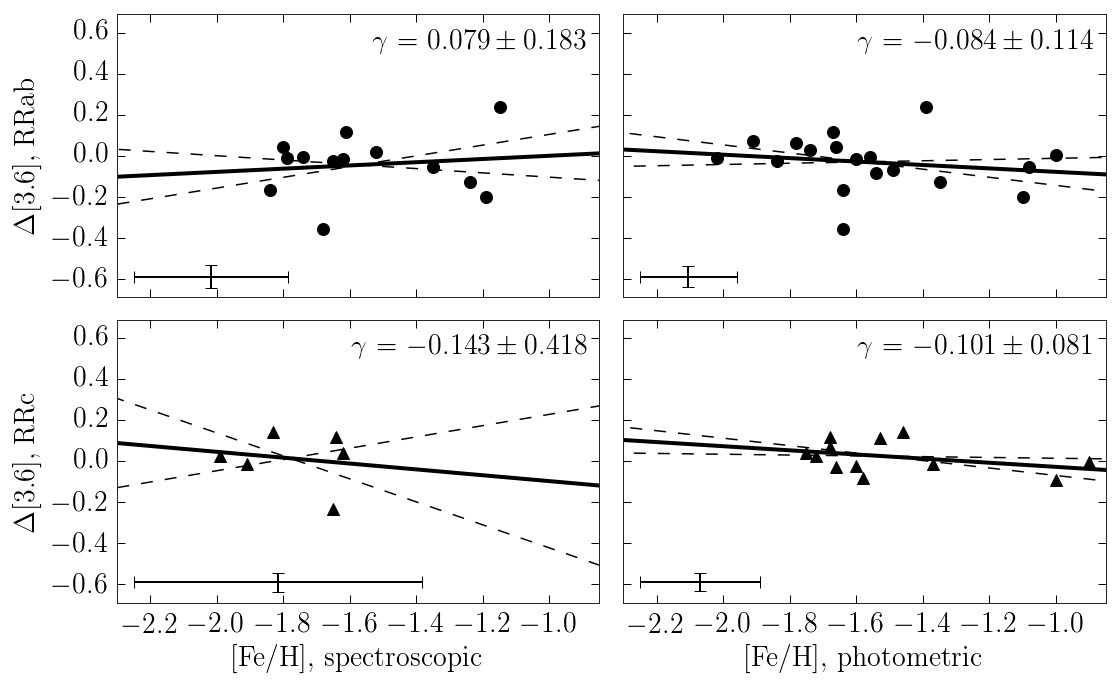

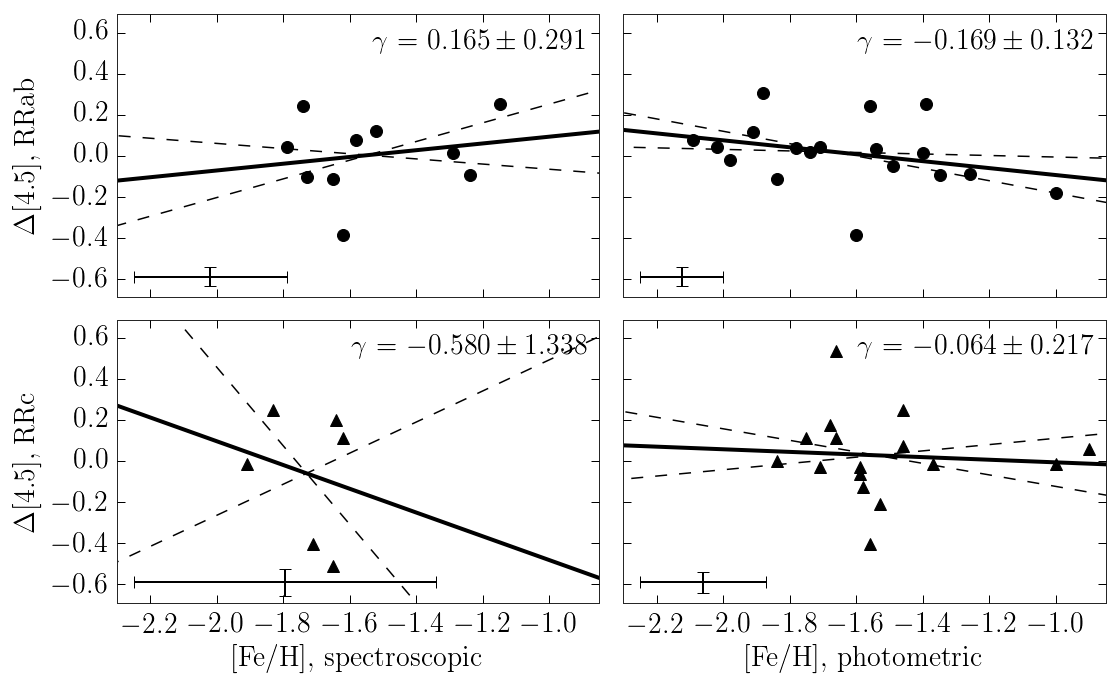

In [10]:
for wav,lam in [('J',1.22),('H',1.63),('K',2.19),('3',3.55),('4',4.493)]:
    make_plot(wav,df,lam)

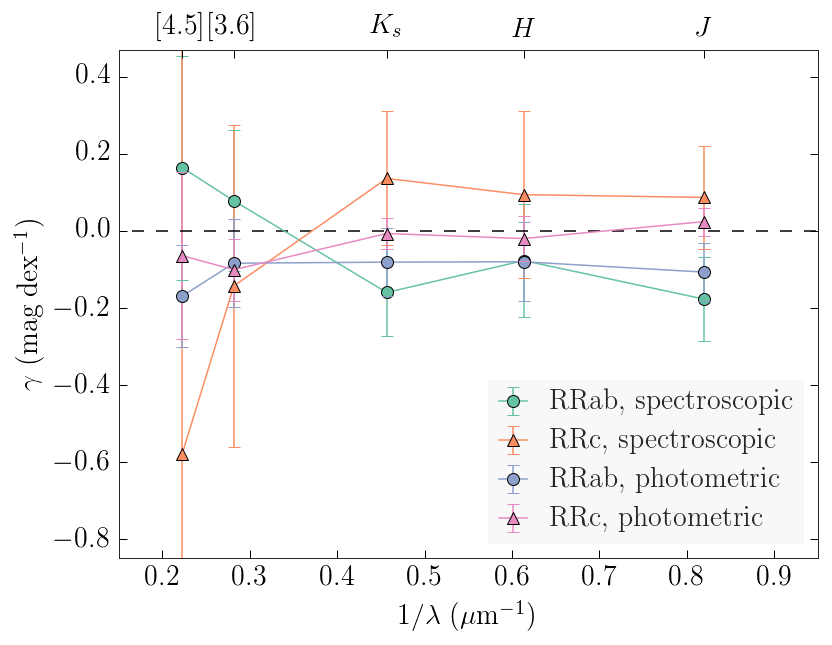

In [62]:
dfx = pd.read_csv('final_data_files/metallicity_slopes.csv')
fig = plt.figure(figsize=(6,4.7))
for fehtype in dfx.fehtype.unique():
    for mode in dfx['mode'].unique():
        dfn = dfx[(dfx.fehtype == fehtype) & (dfx['mode'] == mode)]
        if mode == 'RRab':
            ppl.errorbar(1/dfn['lam'], dfn['slope'], yerr=dfn['sloperr'].values, fmt='o-',
                         label='{}, {}'.format(mode, fehtype))
        else:
            ppl.errorbar(1/dfn['lam'], dfn['slope'], yerr=dfn['sloperr'].values, fmt='^-',
                         label='{}, {}'.format(mode, fehtype))
plt.xlim(0.15,0.95)
plt.ylim(-1.05,0.47)
plt.xlabel(r'$1/\lambda\ (\mu\mathrm{m}^{-1})$')
plt.ylabel(r'$\gamma$ (mag dex$^{-1}$)')
plt.hlines(0,0,1,'k',linestyle='--',linewidth=0.75)
ppl.legend()
ax2 = plt.twiny()
ax2.set_xlim(0.15,0.95)
ax2.set_ylim(-0.85,0.47)
#ax2.xaxis.set_ticks_position('none')
ppl.plot(ax2,[],[])
ax2.set_xticks(1/dfn['lam'])
ax2.set_xticklabels(['$J$', '$H$',  '$K_s$', '[3.6]', '[4.5]'])
plt.tight_layout()
plt.savefig('final_plots/metallicity_slope_vs_wavelength.pdf')